# Model Explorer

This notebook analyzes the trained 1D CNN gravitational wave detection model: how it performs, where it fails, and what features it has learned. For the data and preprocessing context, see [01_data_exploration.ipynb](01_data_exploration.ipynb) first.

> **Requirements** -- Trained model weights, a precomputed average PSD (`avg_psd.npz`),
> and raw samples. If the full dataset (~70 GB) is not available locally, it will
> automatically download a 1000-sample exploration subset (~100 MB) from Kaggle that
> includes the PSD and latest model weights. 

## 1. Setup

In [1]:
import sys
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# find project root and add src to path
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "src").exists() and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from data import (
    find_dataset_dir, download_sample_dataset, load_labels, load_sample,
    preprocess_sample, load_psd, FS, N,
)
from data.g2net import sample_dataset_dir
from models.diy_model import DIYModel
from visualization import (
    plot_confusion_matrix, plot_prediction_distribution,
    plot_roc_curve, plot_precision_recall_curve, DETECTOR_NAMES,
)

print(f"PyTorch: {torch.__version__}")

PyTorch: 2.9.1+cpu


In [2]:
# ---- model selection ----
# set to None for the latest model, or e.g. '20260126_1842' for a specific run
MODEL_DATE = None

# ---- find model weights ----
models_dirs = [
    PROJECT_ROOT / "kaggle" / "output" / "models" / "saved",
    sample_dataset_dir(PROJECT_ROOT) / "models" / "saved",
]
MODELS_DIR = next((d for d in models_dirs if d.exists() and list(d.glob("diy_*_weights.pt"))), models_dirs[0])

weight_files = sorted(MODELS_DIR.glob("diy_*_weights.pt"), reverse=True)
if MODEL_DATE:
    weight_files = [f for f in weight_files if MODEL_DATE in f.name]
if not weight_files:
    raise FileNotFoundError(f"No model weights found in {MODELS_DIR}")

weights_path = weight_files[0]
date_tag = weights_path.stem.replace("diy_", "").replace("_weights", "")
config_path = MODELS_DIR / f"diy_{date_tag}_config.json"
metrics_path = MODELS_DIR / f"diy_{date_tag}_metrics.json"

# load config
if config_path.exists():
    with open(config_path) as f:
        saved_config = json.load(f)
else:
    saved_config = {}

model = DIYModel(
    n_samples=saved_config.get("n_samples", 4096),
    dropout_rate=saved_config.get("dropout_rate", 0.5),
)
model.load_weights(str(weights_path))
model.eval()

print(f"Model: {date_tag}  ({weights_path.name})")
if metrics_path.exists():
    with open(metrics_path) as f:
        saved_metrics = json.load(f)
    if "val_metrics" in saved_metrics:
        vm = saved_metrics["val_metrics"]
        print(f"  Saved val metrics: acc={vm.get('accuracy', 0):.4f}  auc={vm.get('auc', 0):.4f}")

Model: 20260216_1156  (diy_20260216_1156_weights.pt)
  Saved val metrics: acc=0.7810  auc=0.8518


In [3]:
# ---- load PSD, dataset, and validation samples ----
psd_candidates = [
    PROJECT_ROOT / "kaggle" / "output" / "avg_psd.npz",
    PROJECT_ROOT / "avg_psd.npz",
    sample_dataset_dir(PROJECT_ROOT) / "avg_psd.npz",
]
psd_path = next((p for p in psd_candidates if p.exists()), None)
if psd_path is None:
    raise FileNotFoundError("avg_psd.npz not found.")
avg_psd = load_psd(psd_path)

try:
    dataset_dir = find_dataset_dir()
except FileNotFoundError:
    dataset_dir = download_sample_dataset()
labels_df = load_labels(dataset_dir)

# load balanced validation set
N_VAL_SAMPLES = 1000
n_per_class = min(
    N_VAL_SAMPLES // 2,
    (labels_df["target"] == 1).sum(),
    (labels_df["target"] == 0).sum(),
)
val_df = pd.concat([
    labels_df[labels_df["target"] == 1].sample(n=n_per_class, random_state=42),
    labels_df[labels_df["target"] == 0].sample(n=n_per_class, random_state=42),
]).sample(frac=1, random_state=42)

X_val, y_val, val_ids = [], [], []
for _, row in val_df.iterrows():
    raw = load_sample(row["id"], dataset_dir=dataset_dir)
    X_val.append(preprocess_sample(raw, avg_psd))
    y_val.append(row["target"])
    val_ids.append(row["id"])
X_val = np.array(X_val)
y_val = np.array(y_val)

print(f"PSD: {psd_path.name}")
print(f"Dataset: {dataset_dir}")
print(f"Validation samples: {len(X_val)} ({(y_val == 1).sum()} signal, {(y_val == 0).sum()} noise)")

PSD: avg_psd.npz
Dataset: D:\Programming\g2net-gravitational-wave-detection
Validation samples: 1000 (500 signal, 500 noise)


## 2. Single Sample Prediction

Before batch metrics, let's see how the model handles individual samples. The input is the preprocessed (whitened, normalized) signal, the same transformation shown in [01_data_exploration.ipynb](01_data_exploration.ipynb).

In [4]:
def predict_sample(model, raw, avg_psd):
    """Preprocess and predict. Returns (probability, predicted_class, preprocessed)."""
    processed = preprocess_sample(raw, avg_psd)
    prob = model.predict_proba(processed[np.newaxis, ...])[0]
    return prob, int(prob >= 0.5), processed


# signal sample
sig_row = labels_df[labels_df["target"] == 1].sample(1, random_state=42).iloc[0]
raw_signal = load_sample(sig_row["id"], dataset_dir=dataset_dir)
prob_s, pred_s, proc_s = predict_sample(model, raw_signal, avg_psd)

# noise sample
noi_row = labels_df[labels_df["target"] == 0].sample(1, random_state=42).iloc[0]
raw_noise = load_sample(noi_row["id"], dataset_dir=dataset_dir)
prob_n, pred_n, proc_n = predict_sample(model, raw_noise, avg_psd)

print(f"Signal sample ({sig_row['id']}): p={prob_s:.4f}  predicted={'SIGNAL' if pred_s else 'NOISE'}  {'correct' if pred_s == 1 else 'WRONG'}")
print(f"Noise sample  ({noi_row['id']}): p={prob_n:.4f}  predicted={'SIGNAL' if pred_n else 'NOISE'}  {'correct' if pred_n == 0 else 'WRONG'}")

c:\Users\jose\OneDrive\Ambiente de Trabalho\lisa_gravitational_wave_detector\.venv\Lib\site-packages\torch\nn\modules\conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv1d(


Signal sample (882722dba9): p=0.9996  predicted=SIGNAL  correct
Noise sample  (05552e5b6a): p=0.3668  predicted=NOISE  correct


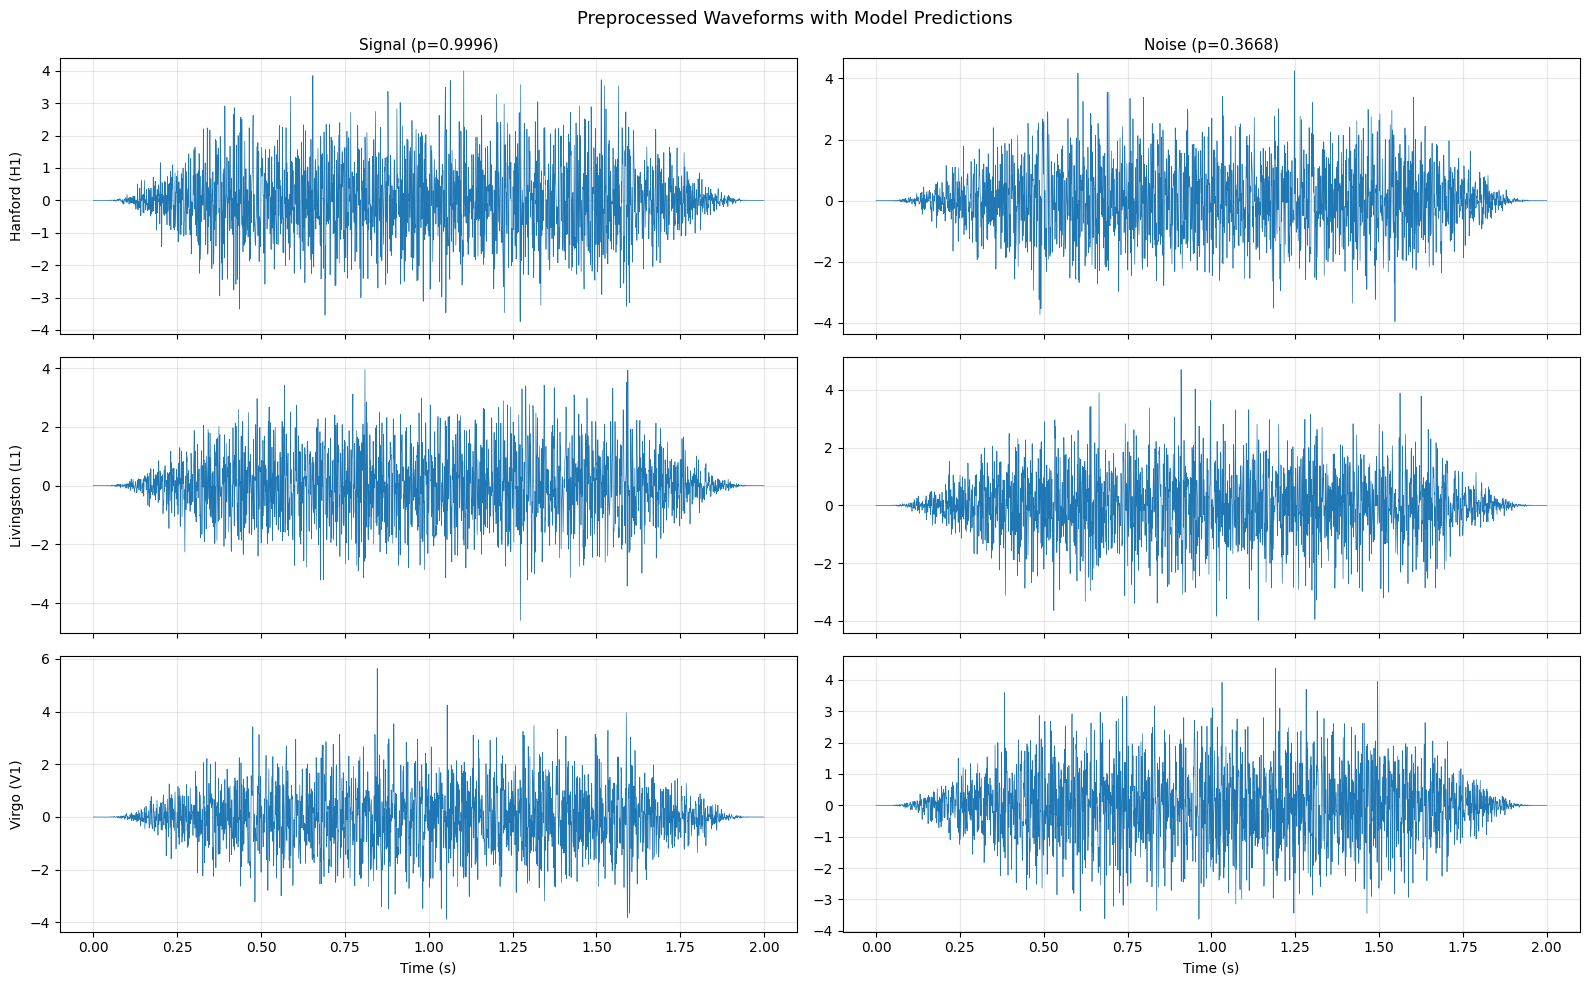

In [5]:
# show preprocessed waveforms for both
time = np.arange(N) / FS
fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharex=True)

for i in range(3):
    for col, (data, label, prob) in enumerate([
        (proc_s, "Signal", prob_s), (proc_n, "Noise", prob_n)
    ]):
        ax = axes[i, col]
        ax.plot(time, data[i], linewidth=0.5)
        ax.grid(True, alpha=0.3)
        if i == 0:
            ax.set_title(f"{label} (p={prob:.4f})", fontsize=11)
        if col == 0:
            ax.set_ylabel(DETECTOR_NAMES[i], fontsize=10)

axes[2, 0].set_xlabel("Time (s)")
axes[2, 1].set_xlabel("Time (s)")
fig.suptitle("Preprocessed Waveforms with Model Predictions", fontsize=13)
plt.tight_layout()
plt.show()

## 3. Model Performance

Now let's evaluate the model across the full validation set.

In [6]:
y_proba = model.predict_proba(X_val)
y_pred = (y_proba >= 0.5).astype(int)
metrics = model.evaluate(X_val, y_val)

print("VALIDATION METRICS")
print("=" * 40)
for k, v in metrics.items():
    print(f"  {k:<15s} {v:.4f}")

VALIDATION METRICS
  accuracy        0.8010
  precision       0.8753
  recall          0.7020
  specificity     0.9000
  f1              0.7791


### Prediction Distribution

A well-separated distribution (noise clustered near 0, signal near 1) indicates confident, correct predictions. Overlap near 0.5 shows where the model is uncertain.

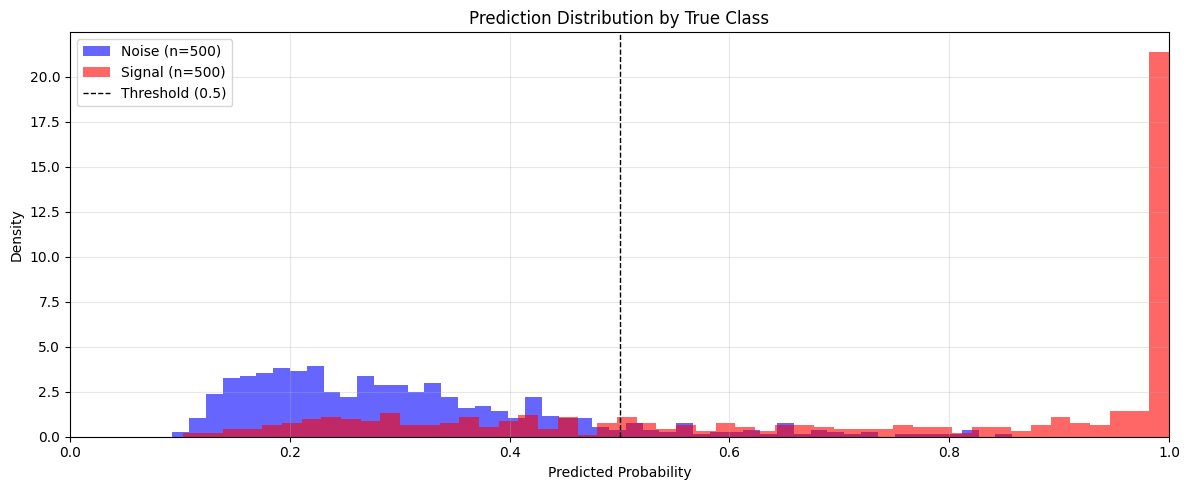

In [7]:
plot_prediction_distribution(y_proba, y_val, bins=50, figsize=(12, 5))
plt.show()

### ROC Curve

The ROC curve shows the tradeoff between true positive rate (detecting real signals) and false positive rate (triggering on noise) across all classification thresholds. AUC = 1.0 means perfect separation; AUC = 0.5 means random guessing.

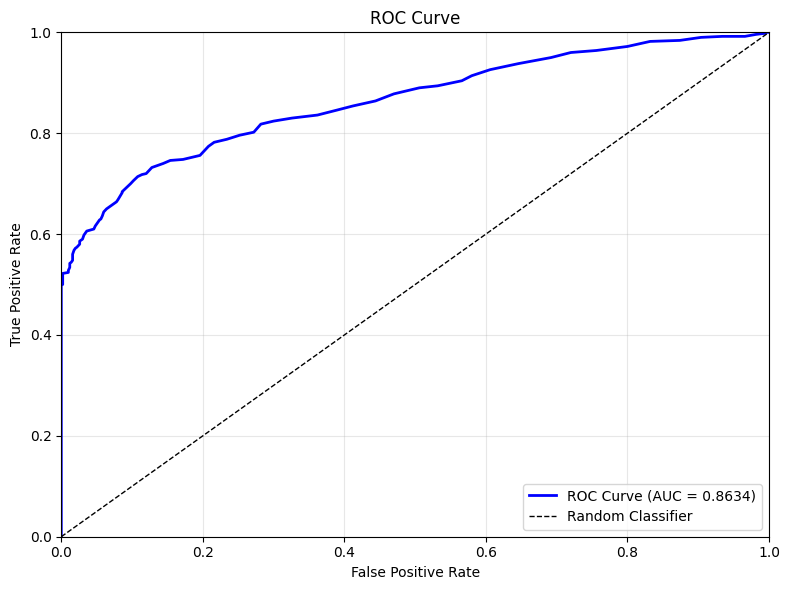

AUC: 0.8634


In [8]:
roc_data = model.roc_curve(X_val, y_val)
plot_roc_curve(roc_data)
plt.show()
print(f"AUC: {roc_data['auc']:.4f}")

### Precision-Recall Curve

Precision-recall is more informative than ROC when the dataset is imbalanced (ours is balanced, but it still shows how precision degrades as we push for higher recall).

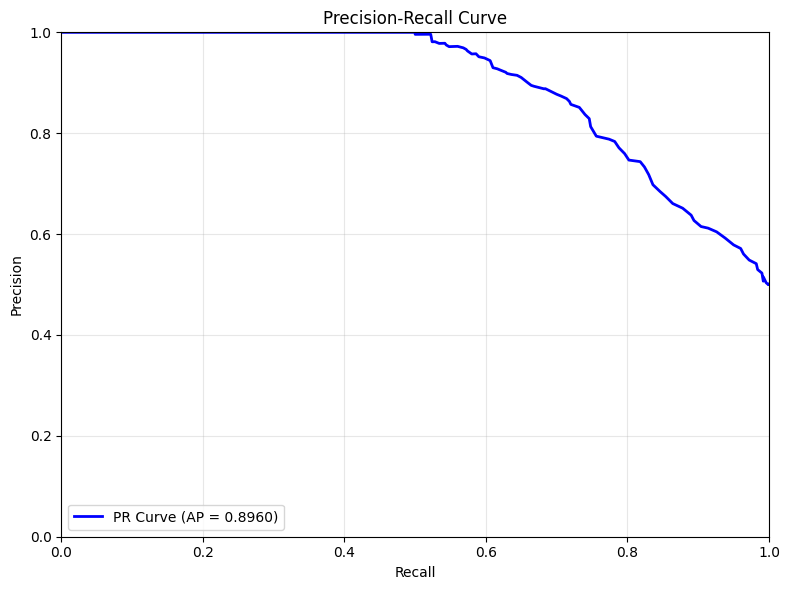

Average Precision: 0.8960


In [9]:
pr_data = model.precision_recall_curve(X_val, y_val)
plot_precision_recall_curve(pr_data)
plt.show()
print(f"Average Precision: {pr_data['ap']:.4f}")

### Confusion Matrix

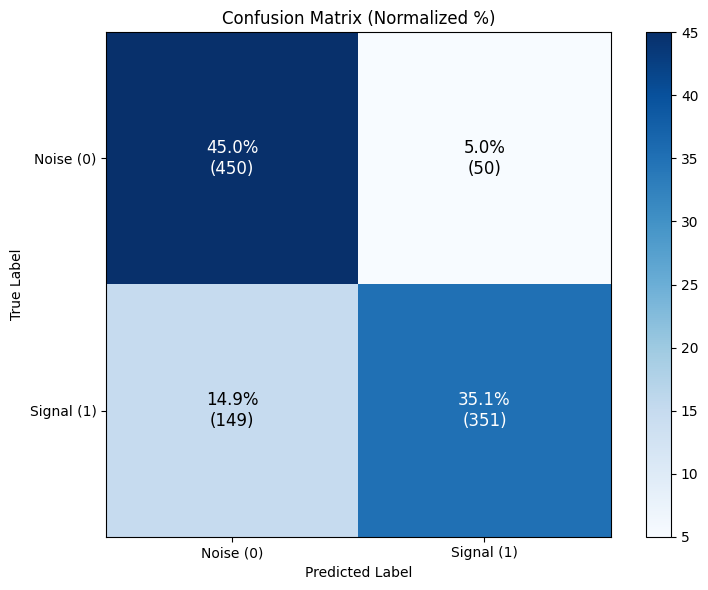

TP=351  TN=450  FP=50  FN=149


In [10]:
cm_data = model.confusion_matrix(X_val, y_val)
plot_confusion_matrix(cm_data, normalize=True)
plt.show()

print(f"TP={cm_data['TP']}  TN={cm_data['TN']}  FP={cm_data['FP']}  FN={cm_data['FN']}")

### Metrics vs Threshold

The default threshold is 0.5, but a different threshold may optimize for precision, recall, or F1.

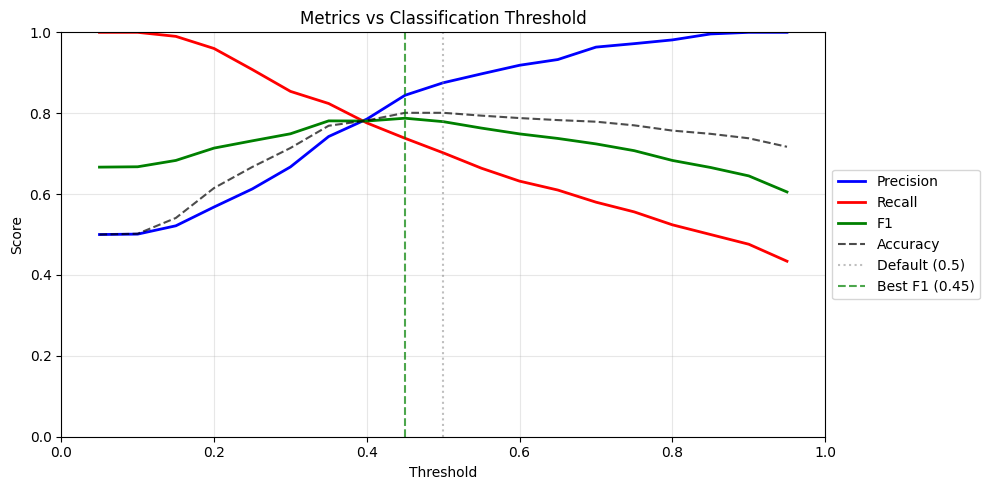

Optimal F1 threshold: 0.45 (F1=0.7876)


In [11]:
thresholds = np.arange(0.05, 1.0, 0.05)
prec_list, rec_list, f1_list, acc_list = [], [], [], []

for t in thresholds:
    yp = (y_proba >= t).astype(int)
    TP = ((yp == 1) & (y_val == 1)).sum()
    TN = ((yp == 0) & (y_val == 0)).sum()
    FP = ((yp == 1) & (y_val == 0)).sum()
    FN = ((yp == 0) & (y_val == 1)).sum()
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0
    rec = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    acc_list.append((TP + TN) / len(y_val))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(thresholds, prec_list, "b-", label="Precision", linewidth=2)
ax.plot(thresholds, rec_list, "r-", label="Recall", linewidth=2)
ax.plot(thresholds, f1_list, "g-", label="F1", linewidth=2)
ax.plot(thresholds, acc_list, "k--", label="Accuracy", linewidth=1.5, alpha=0.7)
ax.axvline(x=0.5, color="gray", linestyle=":", alpha=0.5, label="Default (0.5)")

best_f1_idx = np.argmax(f1_list)
ax.axvline(x=thresholds[best_f1_idx], color="green", linestyle="--", alpha=0.7,
           label=f"Best F1 ({thresholds[best_f1_idx]:.2f})")

ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.set_title("Metrics vs Classification Threshold")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()

print(f"Optimal F1 threshold: {thresholds[best_f1_idx]:.2f} (F1={f1_list[best_f1_idx]:.4f})")

## 4. Error Analysis

Understanding where the model fails is more informative than where it succeeds.

In [ ]:
def find_errors(y_proba, y_true, val_ids, error_type="FP", n=5):
    """Find false positives or false negatives, sorted by confidence."""
    y_pred = (y_proba >= 0.5).astype(int)
    if error_type == "FP":
        mask = (y_pred == 1) & (y_true == 0)
        sort_key = lambda idx: -y_proba[idx]  # highest prob first
    else:
        mask = (y_pred == 0) & (y_true == 1)
        sort_key = lambda idx: y_proba[idx]  # lowest prob first
    indices = sorted(np.where(mask)[0], key=sort_key)
    return [(val_ids[i], y_proba[i], y_true[i]) for i in indices[:n]]


def plot_error_gallery(errors, title, dataset_dir, avg_psd, figsize=(16, 4)):
    """Thumbnail gallery of misclassified samples."""
    n = len(errors)
    if n == 0:
        print(f"{title}: no errors found.")
        return
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    for ax, (sid, prob, label) in zip(axes, errors):
        raw = load_sample(sid, dataset_dir=dataset_dir)
        processed = preprocess_sample(raw, avg_psd)
        for i in range(3):
            ax.plot(processed[i] + i * 5, linewidth=0.3, alpha=0.8)
        actual = "S" if label == 1 else "N"
        ax.set_title(f"p={prob:.3f} ({actual})", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(title, fontsize=11)
    plt.tight_layout()
    return fig

### False Positives

Noise samples the model incorrectly labels as signals. These reveal what noise patterns fool the model -- possibly glitches or accidental cross-detector correlations.

Total false positives: 50
  d713e6cc33: p=0.8573
  40c632ab94: p=0.8157
  1b2b9b6cf8: p=0.8131
  af4d882e7b: p=0.8130
  a6e6bb55bb: p=0.8093


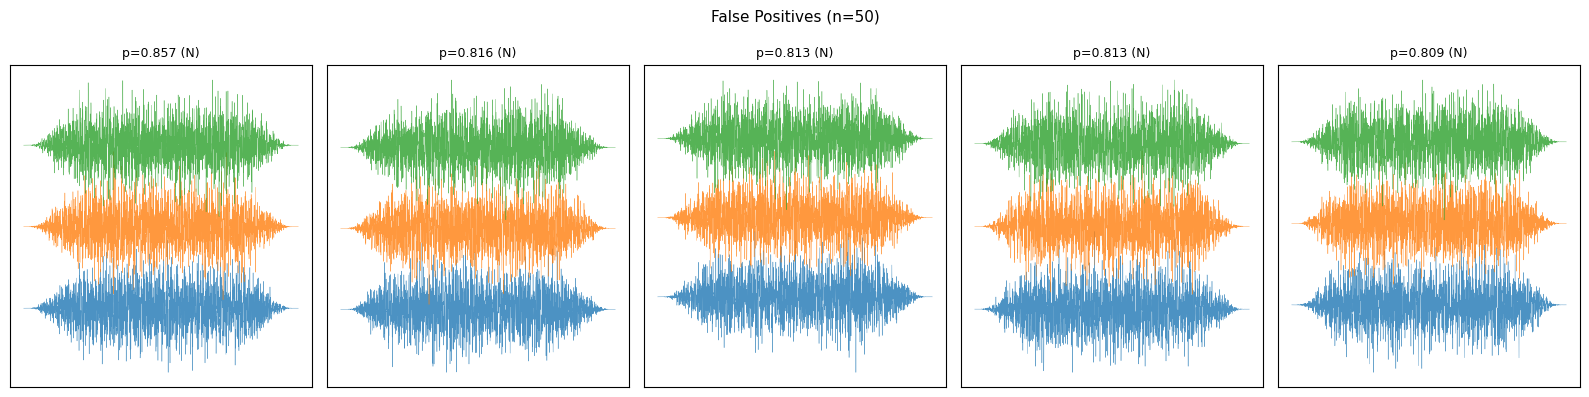

In [13]:
false_positives = find_errors(y_proba, y_val, val_ids, "FP", n=5)
print(f"Total false positives: {cm_data['FP']}")
for sid, prob, _ in false_positives:
    print(f"  {sid}: p={prob:.4f}")

if false_positives:
    plot_error_gallery(false_positives, f"False Positives (n={cm_data['FP']})", dataset_dir, avg_psd)
    plt.show()

### False Negatives

Signal samples the model misses. The lowest-SNR signals are genuinely undetectable -- even an optimal detector would miss them (see [THE_SCIENCE.md](../THE_SCIENCE.md#detection-limits)). The question is whether the model's misses cluster at low SNR (expected) or also include stronger signals (a problem).

Total false negatives: 149
  6bc5f2b571: p=0.1031
  3f3e77cd25: p=0.1199
  2596a0cb2e: p=0.1290
  c5430c0ad5: p=0.1305
  b504cbadf9: p=0.1478


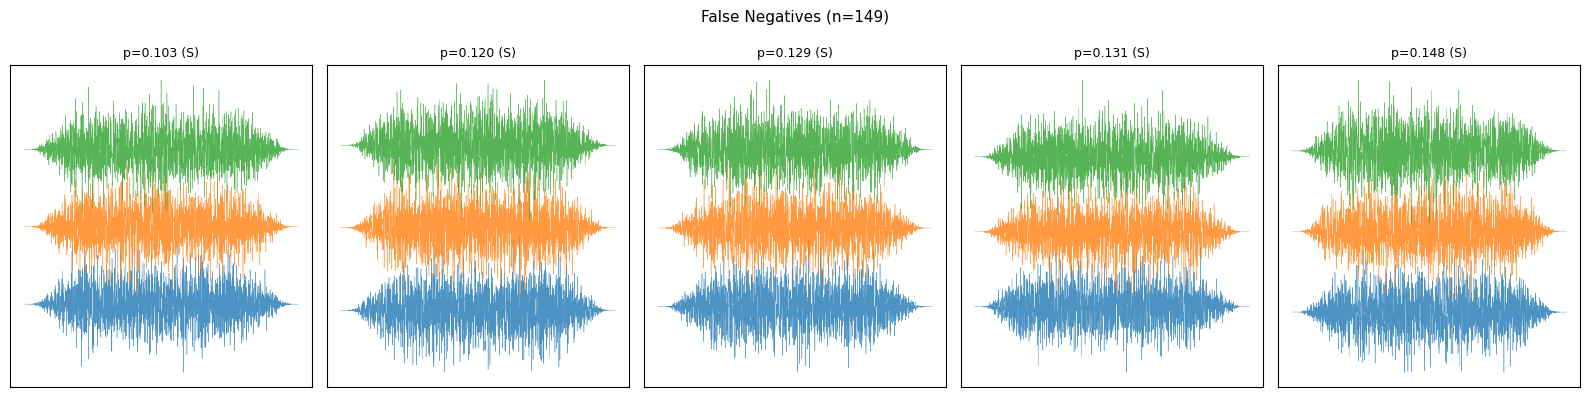

In [14]:
false_negatives = find_errors(y_proba, y_val, val_ids, "FN", n=5)
print(f"Total false negatives: {cm_data['FN']}")
for sid, prob, _ in false_negatives:
    print(f"  {sid}: p={prob:.4f}")

if false_negatives:
    plot_error_gallery(false_negatives, f"False Negatives (n={cm_data['FN']})", dataset_dir, avg_psd)
    plt.show()

## 5. Model Interpretability

What has the model actually learned? We look at three things: which parts of the input most influence predictions (saliency), what the first-layer filters have learned (frequency response), and how intermediate representations evolve through the network (activations).

### Input Saliency

Input saliency shows which time regions most influence the model's output, computed as the gradient of the prediction with respect to each input sample. For a real signal, we expect the model to attend to the final portion of the window where the merger chirp peaks, as the inspiral builds up over the 2 seconds and the coalescence occurs near the end.

In [15]:
def compute_saliency(model, processed):
    """Compute smoothed input saliency (|grad output / grad input|), normalized per detector."""
    model.eval()
    X_tensor = torch.tensor(processed[np.newaxis, ...], dtype=torch.float32, requires_grad=True)
    pred = model(X_tensor)
    pred.backward()
    grads = np.abs(X_tensor.grad.numpy()[0])  # (3, 4096)

    # smooth with moving average
    kernel = np.ones(64) / 64
    saliency = np.zeros_like(grads)
    for i in range(3):
        saliency[i] = np.convolve(grads[i], kernel, mode="same")
        mx = saliency[i].max()
        if mx > 0:
            saliency[i] /= mx

    return saliency, pred.item()


def plot_saliency(processed, saliency, prediction, label, sample_id, figsize=(14, 8)):
    """Overlay saliency heatmap on the signal for all 3 detectors."""
    time = np.arange(N) / FS
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.plot(time, processed[i], "b-", linewidth=0.5, alpha=0.7)
        ax2 = ax.twinx()
        ax2.fill_between(time, 0, saliency[i], alpha=0.3, color="red")
        ax2.set_ylim([0, 1.5])
        ax2.set_ylabel("Importance", color="red")
        ax2.tick_params(axis="y", labelcolor="red")
        ax.set_ylabel(DETECTOR_NAMES[i])
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Time (s)")
    label_str = "Signal" if label == 1 else "Noise"
    pred_str = "Signal" if prediction >= 0.5 else "Noise"
    fig.suptitle(f"Input Saliency -- {label_str} (ID: {sample_id})\n"
                 f"Prediction: {pred_str} (p={prediction:.4f})", fontsize=12)
    plt.tight_layout()
    return fig

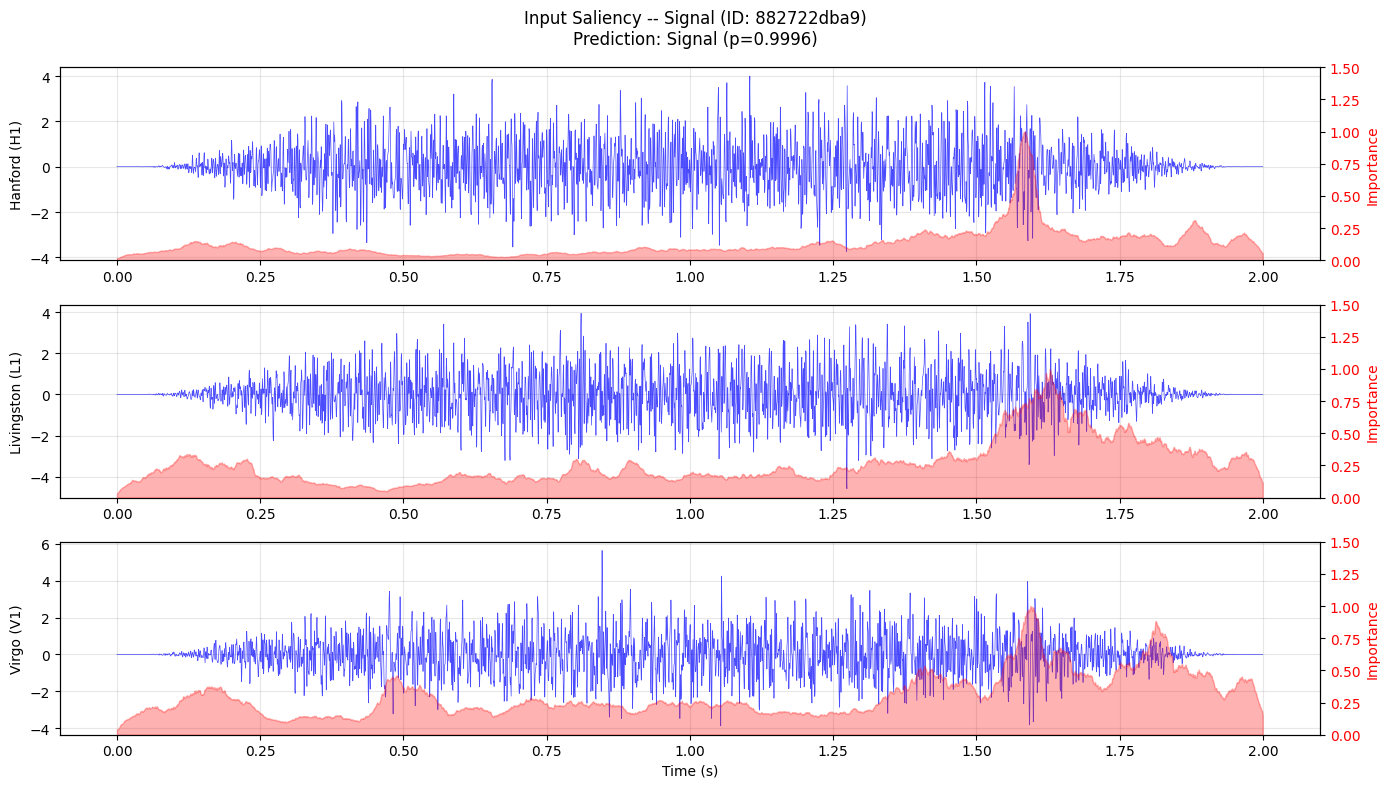

In [16]:
# saliency for signal
sal_s, pred_s = compute_saliency(model, proc_s)
plot_saliency(proc_s, sal_s, pred_s, 1, sig_row["id"])
plt.show()

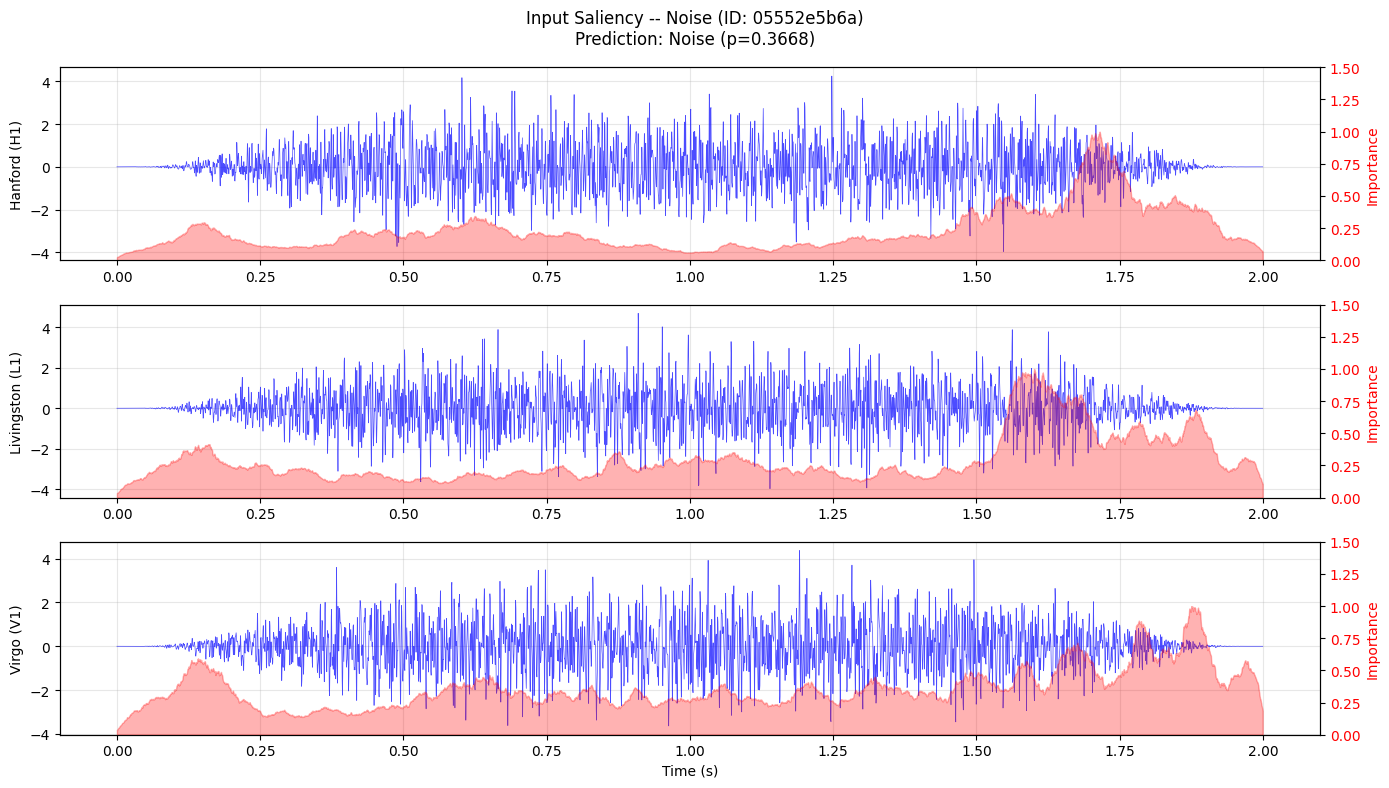

In [17]:
# saliency for noise
sal_n, pred_n = compute_saliency(model, proc_n)
plot_saliency(proc_n, sal_n, pred_n, 0, noi_row["id"])
plt.show()

### Learned Filters

The first convolutional layer has 32 filters of size 64 (~31 ms at 2048 Hz). Each filter slides across the input and fires when the local signal matches its pattern. The frequency response below shows which frequency bands each filter is tuned to -- filters that peak within the signal band (20-500 Hz) are doing useful work; filters peaking outside it are likely responding to residual noise.

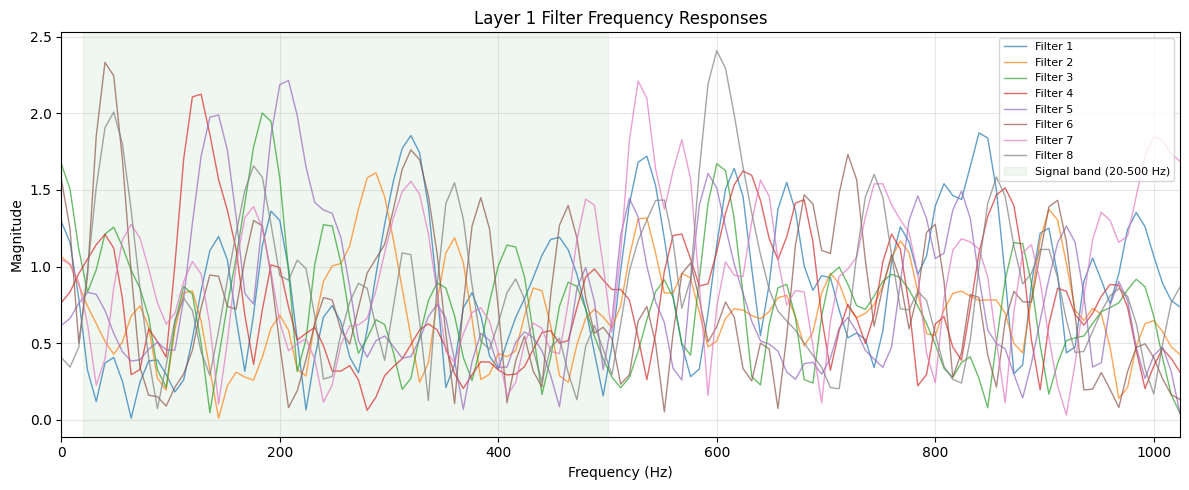

In [18]:
# frequency response of first-layer filters
# PyTorch Conv1d weight shape: (out_channels, in_channels, kernel_size)
weights = model.conv_blocks[0][0].weight.detach().numpy()[:, 0, :]  # (n_filters, kernel_size)
n_show_freq = min(8, weights.shape[0])

fig, ax = plt.subplots(figsize=(12, 5))
for i in range(n_show_freq):
    fft_vals = np.abs(np.fft.rfft(weights[i], n=256))
    freqs = np.fft.rfftfreq(256, d=1 / FS)
    ax.plot(freqs, fft_vals, linewidth=1, alpha=0.7, label=f"Filter {i+1}")

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude")
ax.set_title("Layer 1 Filter Frequency Responses")
ax.axvspan(20, 500, alpha=0.06, color="green", label="Signal band (20-500 Hz)")
ax.set_xlim([0, FS / 2])
ax.legend(loc="upper right", fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Intermediate Activations

How the signal representation evolves through the convolutional layers. Each row shows activations from one layer (first 16 filters), with time on the x-axis. Deeper layers capture progressively more abstract features.

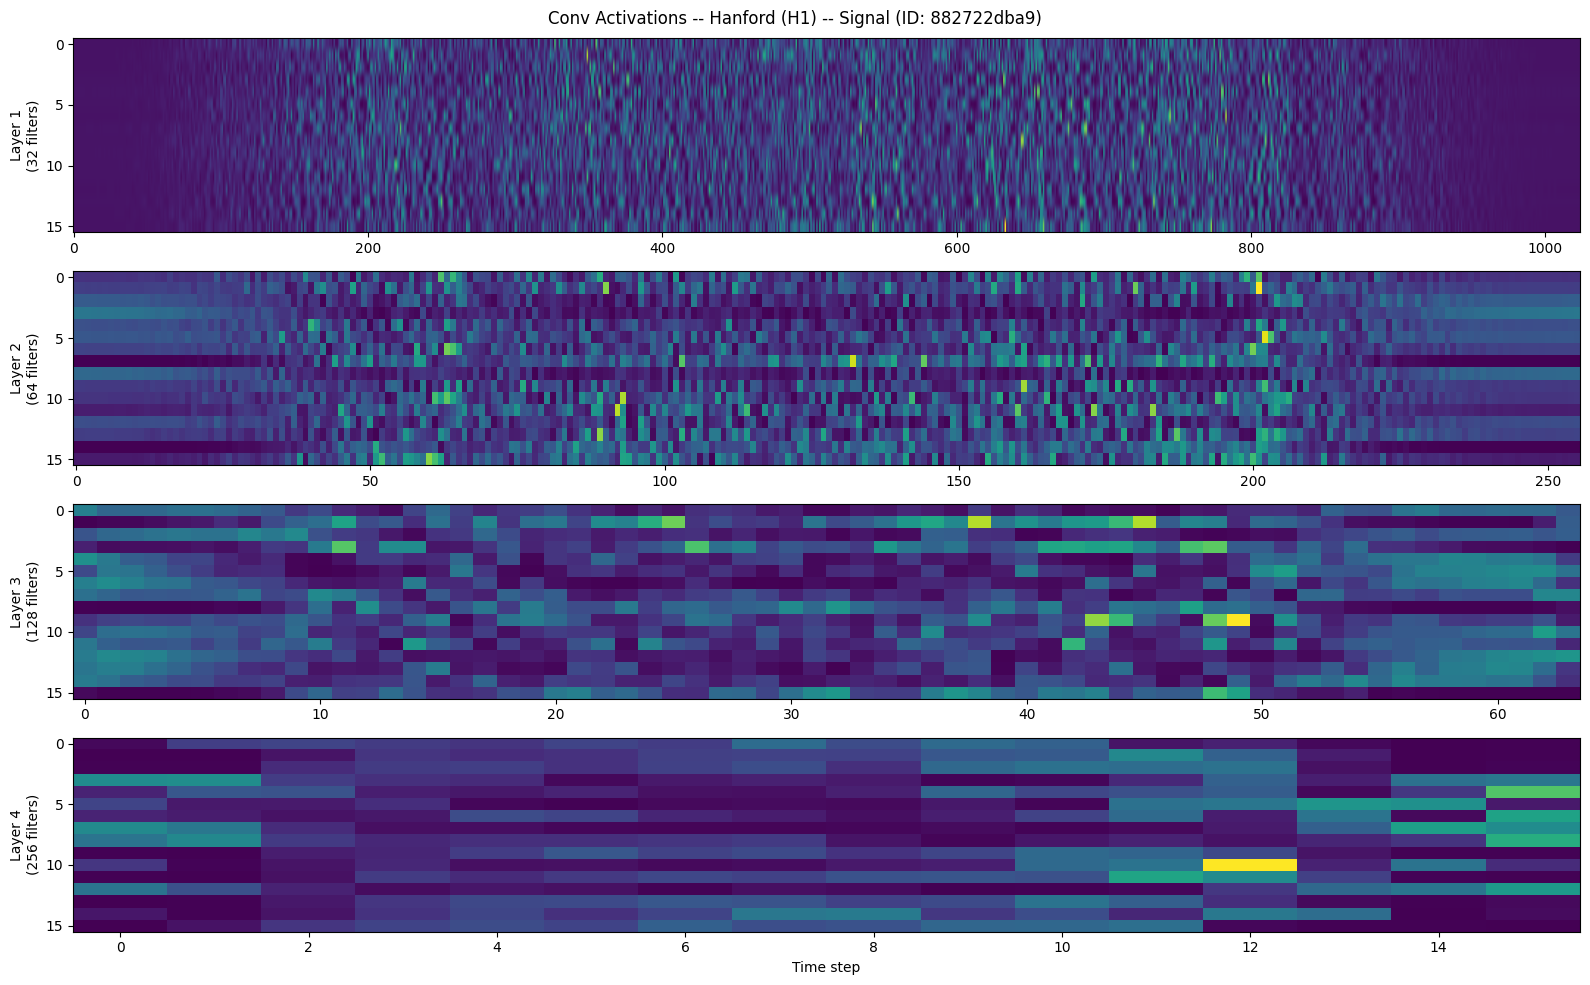

In [19]:
def get_layer_activations(model, processed, detector_idx=0):
    """Get activations from each conv layer for one detector."""
    model.eval()
    with torch.no_grad():
        x = torch.tensor(processed[np.newaxis, ...], dtype=torch.float32)
        x = x[:, detector_idx, :].unsqueeze(1)  # (1, 1, 4096)
        activations = []
        for block in model.conv_blocks:
            x = block(x)
            # PyTorch: (batch, channels, time) -> transpose to (time, channels) for plotting
            activations.append(x.numpy()[0].T)
    return activations


def plot_activations(processed, label, sample_id, model, detector_idx=0,
                     n_filters=16, figsize=(16, 10)):
    """Plot activations from each conv layer."""
    activations = get_layer_activations(model, processed, detector_idx)
    n_layers = len(activations)
    fig, axes = plt.subplots(n_layers, 1, figsize=figsize)

    for idx, (ax, act) in enumerate(zip(axes, activations)):
        n_show = min(n_filters, act.shape[1])
        ax.imshow(act[:, :n_show].T, aspect="auto", cmap="viridis")
        ax.set_ylabel(f"Layer {idx+1}\n({act.shape[1]} filters)")
        if idx == n_layers - 1:
            ax.set_xlabel("Time step")

    label_str = "Signal" if label == 1 else "Noise"
    fig.suptitle(f"Conv Activations -- {DETECTOR_NAMES[detector_idx]} -- {label_str} (ID: {sample_id})",
                 fontsize=12)
    plt.tight_layout()
    return fig


# signal activations
plot_activations(proc_s, 1, sig_row["id"], model, detector_idx=0)
plt.show()

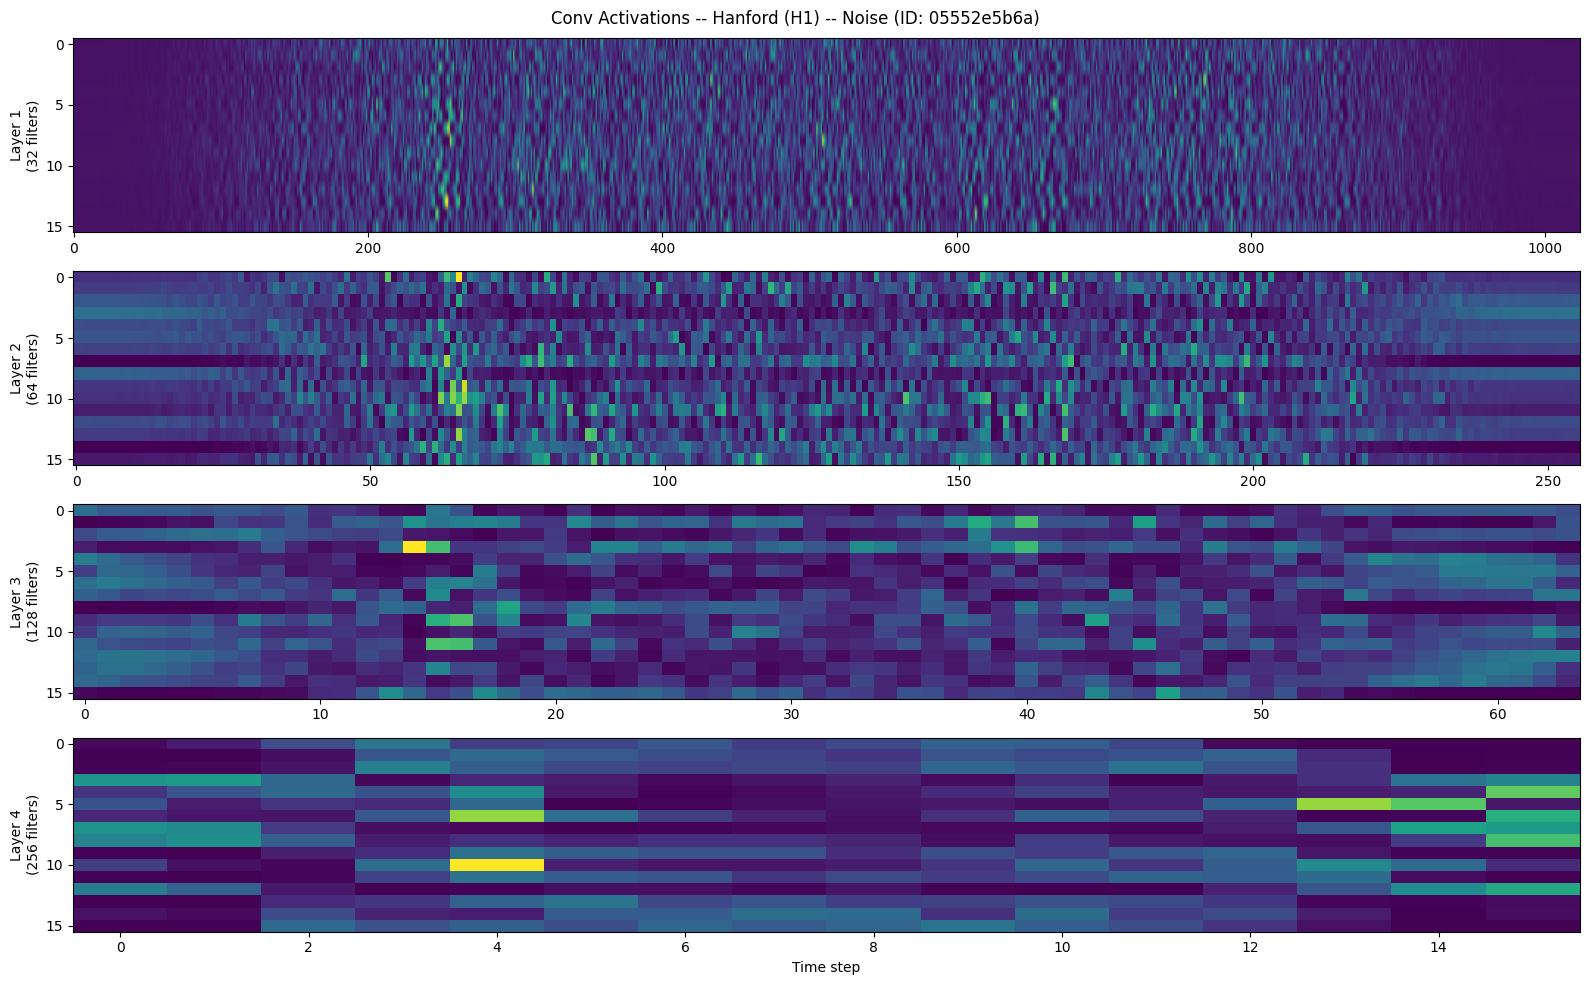

In [20]:
# noise activations for comparison
plot_activations(proc_n, 0, noi_row["id"], model, detector_idx=0)
plt.show()

## 6. What's Next

The model achieves reasonable accuracy but shows signs of overfitting (validation loss diverges after epochs ~3-5 while training loss continues dropping). The error analysis above shows the types of mistakes it makes.

Planned improvements are detailed in [next-steps.md](../next-steps.md):
- **Phase 1 (Optimization)**: Data augmentation, learning rate warmup, stronger regularization.
- **Phase 2 (Physics-Informed Training)**: Embedding physical constraints (cross-detector consistency, time-delay priors, waveform structure) into the loss function.